In [2]:
%matplotlib inline


# Calculating xT (action-based)
Calculate action based Expected Threat once you have
found possession chains.


In [1]:
import pandas as pd
import json
# plotting
import os
import pathlib
import warnings 
from joblib import load
from mplsoccer import Pitch
from itertools import combinations_with_replacement
import xgboost
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

## Opening the dataset

First we open the data. It is the file created in the Possesion Chain segment. The file is prepared using the script
from the [previous section](https://soccermatics.readthedocs.io/en/latest/gallery/lesson4/plot_PossesionChain.html).

In [3]:
file_name = 'possession_chains_England.json'
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', 'possession_chain', file_name)
with open(path) as f:
    data = json.load(f)
df = pd.DataFrame(data)

In [4]:
df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,possesion_chain,possesion_chain_team,xG,shot_end,x0,c0,x1,c1,y0,y1
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,...,0,1609,0.000000,0,51.45,0.68,32.55,19.04,34.68,14.96
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,...,0,1609,0.000000,0,32.55,19.04,53.55,17.00,14.96,17.00
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,...,0,1609,0.000000,0,53.55,17.00,36.75,14.28,17.00,19.72
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,...,0,1609,0.000000,0,36.75,14.28,43.05,30.60,19.72,3.40
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,...,0,1609,0.000000,0,43.05,30.60,75.60,25.84,3.40,8.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643142,8,High pass,[{'id': 1801}],20620,"[{'y': 89, 'x': 53}, {'y': 72, 'x': 99}]",2500098,Pass,1633,2H,2785.702032,...,113381,1633,0.000000,0,55.65,26.52,103.95,14.96,7.48,19.04
643143,8,Cross,"[{'id': 402}, {'id': 2101}, {'id': 1802}]",14703,"[{'y': 72, 'x': 99}, {'y': 0, 'x': 0}]",2500098,Pass,1633,2H,2789.232666,...,113381,1633,0.000000,0,103.95,14.96,0.00,34.00,19.04,68.00
643146,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,...,113382,1633,0.038676,1,105.00,34.00,92.40,2.04,0.00,36.04
643148,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,...,113382,1633,0.038676,1,92.40,2.04,90.30,0.00,36.04,34.00


## Preparing variables for models

For our models we will use all non-linear combinations of the starting and ending
x coordinate and *c* - distance from the middle of the pitch. We create combinations
with replacement of these variables - to get their non-linear transfomations. As the next step,
we multiply the columns in the combination and create a model with them. 



In [5]:
# model variables
var = ["x0", "x1", "c0", "c1"]

# combinations
inputs = []
# one variable combinations
inputs.extend(combinations_with_replacement(var, 1))
# 2 variable combinations
inputs.extend(combinations_with_replacement(var, 2))
# 3 variable combinations 
inputs.extend(combinations_with_replacement(var, 3))

# make new columns
for i in inputs:
    # columns length 1 already exist 
    if len(i) > 1:
        # column name 
        column = ''
        x = 1
        for c in i:
            # add column name to be x0x1c0 for example
            column += c
            # multiply values in column
            x = x*df[c]
        # create a new column in df
        df[column] = x
        # add column to model variables
        var.append(column)
        
# investigate 3 columns
df[var[-3:]].head(3)

,c0c0c1,c0c1c1,c1c1c1
0,8.804096,246.514688,6902.411264
1,6162.867200,5502.560000,4913.000000
2,4126.920000,3466.612800,2911.954752


## Calculating action-based Expected Threat values for passes

To predict the outcome of a chain, we trained a model (XGB classifier) on Bundesliga dataset. In the code we use
model saved in the file which can be found [here](https://github.com/soccermatics/Soccermatics/blob/main/course/lessons/possession_chain/finalized_model.sav). It was trained using *xgboost* library version 1.6.2.
Training steps are provided commented out. Using it we predict
probability of a chain ending with a shot. Then, on chains that ended with a shot, we fit a linear regression 
to calculate the probability that a shot ended with a goal. Product of these 2 values is our action-based Expected Threat statistic.



In [6]:
### TRAINING, it's not perfect ML procedure, but results in AUC 0.2 higher than Logistic Regression ###
# passes = df.loc[df["eventName"].isin(["Pass"])]
# X = passes[var].values - note that this is different X, with data from BL
# y = passes["shot_end"].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 123, stratify = y)
# xgb = XGBRegressor(n_estimators = 100, ccp_alpha=0, max_depth=4, min_samples_leaf=10,
#                        random_state=123)
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(estimator = xgb, X = X_train, y = y_train, cv = 10, n_jobs = -1)
# print(np.mean(scores), np.std(scores))
# xgb.fit(X_train, y_train)
# print(xgb.score(X_train, y_train))
# y_pred = xgb.predict(X_test)
# print(xgb.score(X_test, y_test))

# predict if ended with shot
passes = df.loc[df["eventName"].isin(["Pass"])]
X = passes[var].values
y = passes["shot_end"].values
# path to saved model
path_model = os.path.join(str(pathlib.Path().resolve().parents[0]), 'models', 'chain_ends_w_shot.sav')
model = load(path_model) 
# predict probability of shot ended
y_pred_proba = model.predict_proba(X)[::,1]

passes["shot_prob"] = y_pred_proba
# OLS
shot_ended = passes.loc[passes["shot_end"] == 1]
X2 = shot_ended[var].values
y2 = shot_ended["xG"].values
lr = LinearRegression()
lr.fit(X2, y2)
y_pred = lr.predict(X)
passes["xG_pred"] = y_pred
# calculate xGchain
passes["xT"] = passes["xG_pred"]*passes["shot_prob"]

passes[["xG_pred", "shot_prob", "xT"]].head(5)

,xG_pred,shot_prob,xT
0,0.121099,0.030782,0.003728
1,0.108244,0.044363,0.004802
2,0.121571,0.046617,0.005667
3,0.118808,0.031972,0.003798
4,0.116028,0.052279,0.006066


In [7]:
passes

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,x1c0c0,x1c0c1,x1c1c1,c0c0c0,c0c0c1,c0c1c1,c1c1c1,shot_prob,xG_pred,xT
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,...,15.05112,421.43136,11800.07808,0.314432,8.804096,246.514688,6902.411264,0.030782,0.121099,0.003728
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,...,19413.03168,17333.06400,15475.95000,6902.411264,6162.867200,5502.560000,4913.000000,0.044363,0.108244,0.004802
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,...,10620.75000,8921.43000,7494.00120,4913.000000,4126.920000,3466.612800,2911.954752,0.046617,0.121571,0.005667
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,...,8778.68712,18811.47240,40310.29800,2911.954752,6239.903040,13371.220800,28652.616000,0.031972,0.118808,0.003798
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,...,70788.81600,59777.22240,50478.54336,28652.616000,24195.542400,20431.791360,17253.512704,0.052279,0.116028,0.006066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643134,8,Simple pass,[{'id': 1801}],8313,"[{'y': 63, 'x': 65}, {'y': 96, 'x': 61}]",2500098,Pass,1633,2H,2760.286946,...,5005.22568,17710.79856,62668.97952,690.807104,2444.394368,8649.395456,30605.553152,0.068442,0.108880,0.007452
643135,8,Simple pass,[{'id': 1801}],379209,"[{'y': 96, 'x': 61}, {'y': 85, 'x': 40}]",2500098,Pass,1633,2H,2763.698599,...,41094.41280,31267.48800,23790.48000,30605.553152,23286.833920,17718.243200,13481.272000,0.052370,0.132424,0.006935
643141,8,Simple pass,[{'id': 1801}],8561,"[{'y': 70, 'x': 59}, {'y': 89, 'x': 53}]",2500098,Pass,1633,2H,2783.137836,...,10293.02400,20071.39680,39139.22376,2515.456000,4905.139200,9565.021440,18651.791808,0.059378,0.116290,0.006905
643142,8,High pass,[{'id': 1801}],20620,"[{'y': 89, 'x': 53}, {'y': 72, 'x': 99}]",2500098,Pass,1633,2H,2785.702032,...,73109.11608,41241.03984,23264.17632,18651.791808,10521.523584,5935.218432,3348.071936,0.043201,0.156364,0.006755


## Making a plot of pass values

Now we can make the plot of the pass. This is the same plot as we have seen in 
[previous section](https://soccermatics.readthedocs.io/en/latest/gallery/lesson4/plot_PossesionChain.html) but this time
the value is assigned to passes and line width is proportional to its value.



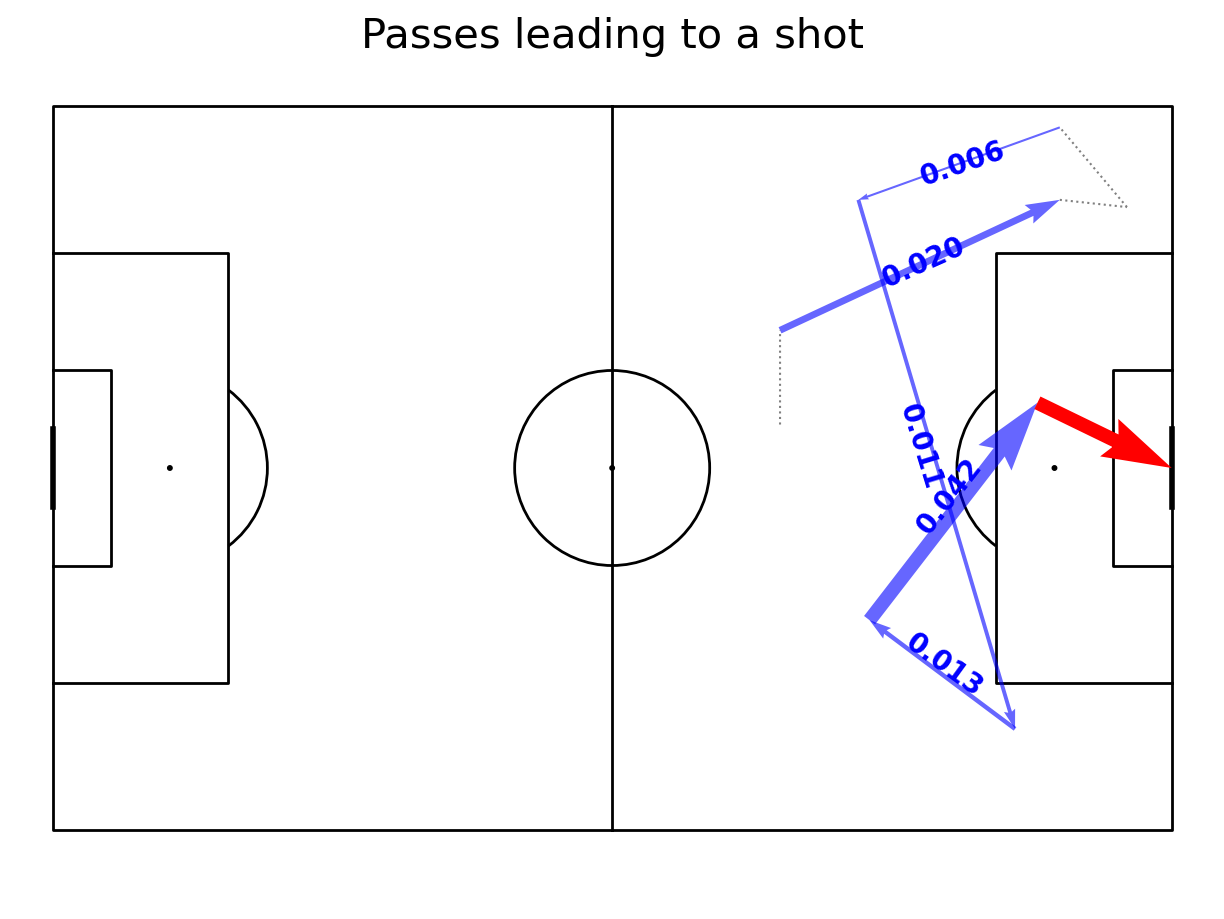

In [6]:
chain = df.loc[df["possesion_chain"] == 4]
#get passes
passes_in = passes.loc[df["possesion_chain"] == 4]
max_value = passes_in["xT"].max()
#get events different than pass
not_pass = chain.loc[chain["eventName"] != "Pass"].iloc[:-1]
#shot is the last event of the chain (or should be)
shot = chain.iloc[-1]
#plot 
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#add size adjusted arrows
for i, row in passes_in.iterrows():
    value = row["xT"]
    #adjust the line width so that the more passes, the wider the line
    line_width = (value / max_value * 10)
    #get angle
    angle = np.arctan((row.y1-row.y0)/(row.x1-row.x0))*180/np.pi
    #plot lines on the pitch
    pitch.arrows(row.x0, row.y0, row.x1, row.y1,
                        alpha=0.6, width=line_width, zorder=2, color="blue", ax = ax["pitch"])
    #annotate text
    ax["pitch"].text((row.x0+row.x1-8)/2, (row.y0+row.y1-4)/2, str(value)[:5], fontweight = "bold", color = "blue", zorder = 4, fontsize = 20, rotation = int(angle))

#shot
pitch.arrows(shot.x0, shot.y0,
            shot.x1, shot.y1, width=line_width, color = "red", ax=ax['pitch'], zorder =  3)
#other passes like arrows
pitch.lines(not_pass.x0, not_pass.y0, not_pass.x1, not_pass.y1, color = "grey", lw = 1.5, ls = 'dotted', ax=ax['pitch'])
ax['title'].text(0.5, 0.5, 'Passes leading to a shot', ha='center', va='center', fontsize=30)
plt.show()

## Finding out players with highest action-based Expected Threat
As the last step we want to find out which players who played more than 400 minutes
scored the best in possesion-adjusted action-based Expected Threat per 90. We repeat steps that you already know 
from [Radar Plots](https://soccermatics.readthedocs.io/en/latest/gallery/lesson3/plot_RadarPlot.html).
We group them by player, sum, assign merge it with players database to keep players name,
adjust per possesion and per 90. Only the last step differs, since we stored *percentage_df*
in a .json file that can be found [here](https://github.com/soccermatics/Soccermatics/tree/main/course/lessons/minutes_played).



In [8]:
summary = passes[["playerId", "xT"]].groupby(["playerId"]).sum().reset_index()
#add player name
path = os.path.join(str(pathlib.Path().resolve().parents[0]),"data", 'Wyscout', 'players.json')
player_df = pd.read_json(path, encoding='unicode-escape')
player_df.rename(columns = {'wyId':'playerId'}, inplace=True)
player_df["role"] = player_df.apply(lambda x: x.role["name"], axis = 1)
to_merge = player_df[['playerId', 'shortName', 'role']]

summary = summary.merge(to_merge, how = "left", on = ["playerId"])

#get minutes
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', 'minutes_played', 'minutes_played_per_game_England.json')
with open(path) as f:
    minutes_per_game = json.load(f)
#filtering over 400 per game
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()
summary = minutes.merge(summary, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]
#calculating per 90
summary["xT_p90"] = summary["xT"]*90/summary["minutesPlayed"]

#adjusting for possesion
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', 'player_possession', 'player_possession_England.json')
with open(path) as f:
    percentage_df = json.load(f)
percentage_df = pd.DataFrame(percentage_df)
#merge it
summary = summary.merge(percentage_df, how = "left", on = ["playerId"])
#adjust per possesion
summary["xT_adjusted_per_90"] = (summary["xT"]/summary["possesion"])*90/summary["minutesPlayed"]
summary[['shortName', 'xT_adjusted_per_90']].sort_values(by='xT_adjusted_per_90', ascending=False).head(5)

,shortName,xT_adjusted_per_90
22,M. Özil,1.552911
27,Fàbregas,1.462536
250,E. Hazard,1.410102
30,A. Sánchez,1.396848
117,David Silva,1.338083


## Challenge
1. StatsBomb has recently released a dataset with Indian Superleague 2021/22 games. Calculate
xGChain values for these player. Note that the possesion chains are already isolated. Which player stood out the most? 

